In [15]:
import torch
import tinycudann as tcnn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# data = torch.load("../output/703df3ad-b/point_cloud/iteration_30000/point_cloud.th")
data = torch.load("../output/703df3ad-b/point_cloud/iteration_30000/point_cloud.th")

In [4]:
network_config = {
    "encoding": {
	    "otype": "Composite",
	    "nested": [
		    {
			    "n_dims_to_encode": 3,
			    # "otype": "SphericalHarmonics",
			    "otype": "Frequency",
			    "degree": 4
		    },
		    {
			    "otype": "Identity"
		    }
	    ]
	},
	"network": {
		"otype": "FullyFusedMLP",
		"activation": "ReLU",
		"output_activation": "None",
		# "n_neurons": 64,
		# "n_hidden_layers": 2
		"n_neurons": 128,
		"n_hidden_layers": 4
	},
}

sh_degree = 3
feat_dim = 3*(sh_degree+1)**2
rgb_network = tcnn.NetworkWithInputEncoding(
    3+feat_dim-3, 3, network_config["encoding"], network_config["network"])


In [5]:
rgb_network.load_state_dict(dict(params=data['rgb_network']))

<All keys matched successfully>

In [9]:
device = torch.device("cuda")
H = 64
W = H*2
rows, cols = torch.meshgrid(
        torch.arange(H),
        torch.arange(W),
        indexing='ij')
rows = rows.reshape(-1)
cols = cols.reshape(-1)
theta = rows/H * np.pi - np.pi/2
phi = -cols/W * 2*np.pi - np.pi

angs = torch.stack([theta, phi], dim=1).reshape(-1, 2).to(device)

vecs = torch.stack([
    torch.cos(phi)*torch.cos(theta),
    torch.sin(phi)*torch.cos(theta),
    -torch.sin(theta),
], dim=1).to(device)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


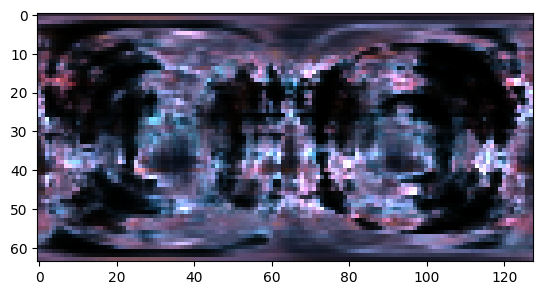

In [23]:
i = 7
feat_dc = data['features_dc'][i]
feat_rest = data['features_rest'][i]

mlp_input = torch.cat([vecs, feat_rest.reshape(1, -1).expand(vecs.shape[0], -1)], dim=1)
# rgb = (feat_dc + 0.1*rgb_network(mlp_input)).exp()
rgb = (feat_dc.exp() + 0.01*rgb_network(mlp_input))
plt.imshow(rgb.reshape(H, W, 3).detach().cpu())